In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define constants
DATA_DIR = '/content/drive/MyDrive/Data folders'
IMG_SIZE = (246, 246)
NUM_CLASSES = 7


In [3]:
# Load images and labels
images = []
labels = []
class_names = os.listdir(DATA_DIR)
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, IMG_SIZE)  # Resize image
        images.append(img)
        labels.append(class_names.index(class_name))

In [4]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)


In [5]:
len(labels)

7040

In [6]:
# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=42)  # 0.25 x 0.8 = 0.2


In [7]:
# Normalize pixel values to range [0, 1] without resizing
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [8]:
X_test[7].max()

1.0

In [9]:
# Convert class labels to one-hot encoded vectors

y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)


In [10]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)


# Model No.1 : ***VGG19***





In [ ]:
from keras.applications import VGG19

# Load the pre-trained VGG16 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top of the pre-trained base
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                         

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/best_model.h5', monitor='val_loss', save_best_only=True)


In [ ]:
# Train the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=16),
                    steps_per_epoch=len(X_train) / 16, epochs=50,
                    validation_data=(X_val, y_val), callbacks=[early_stop, model_checkpoint])


Epoch 1/50
314/313 [==============================] - ETA: 0s - loss: 1.9319 - accuracy: 0.1982

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 115s 336ms/step - loss: 1.9319 - accuracy: 0.1982 - val_loss: 1.7092 - val_accuracy: 0.3092
Epoch 2/50
313/313 [==============================] - 89s 284ms/step - loss: 1.7571 - accuracy: 0.2582 - val_loss: 1.6276 - val_accuracy: 0.3385
Epoch 3/50
313/313 [==============================] - 84s 268ms/step - loss: 1.6875 - accuracy: 0.2851 - val_loss: 1.6156 - val_accuracy: 0.3427
Epoch 4/50
313/313 [==============================] - 93s 295ms/step - loss: 1.6706 - accuracy: 0.3046 - val_loss: 1.5625 - val_accuracy: 0.3804
Epoch 5/50
313/313 [==============================] - 92s 295ms/step - loss: 1.6344 - accuracy: 0.3264 - val_loss: 1.5423 - val_accuracy: 0.3720
Epoch 6/50
313/313 [==============================] - 87s 277ms/step - loss: 1.6242 - accuracy: 0.3276 - val_loss: 1.5276 - val_accuracy: 0.3816
Epoch 7/50
313/313 [==============================] - 92s 292ms/step - loss: 1.6037 - accuracy: 0.3371 - val_loss: 1.5161 - val_accuracy: 0.

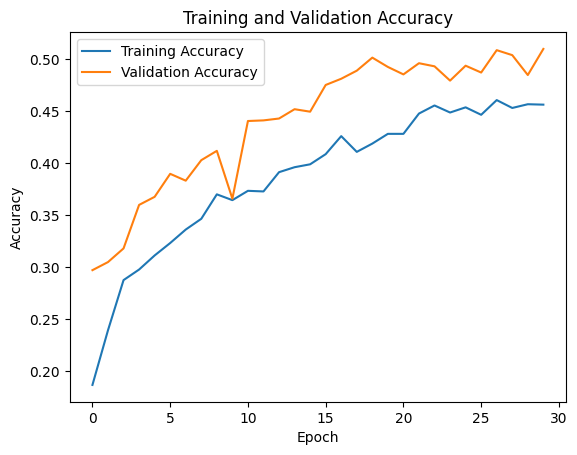

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


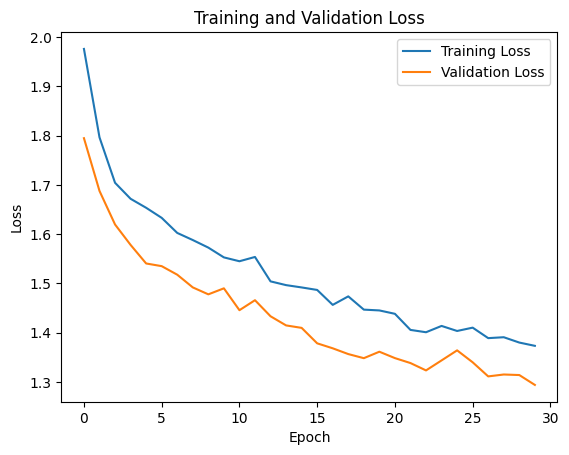

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

11/11 [==============================] - 2s 156ms/step - loss: 1.1886 - accuracy: 0.5625
Test Loss: 1.1885672807693481
Test Accuracy: 0.5625


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))




11/11 [==============================] - 2s 153ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.56      0.61      0.58        46
     disgust       0.57      0.30      0.40        56
        fear       0.66      0.43      0.52        49
    surprise       0.67      0.66      0.66        64
     neutral       0.50      0.68      0.58        44
         sad       0.39      0.50      0.44        38
       happy       0.60      0.75      0.67        55

    accuracy                           0.56       352
   macro avg       0.56      0.56      0.55       352
weighted avg       0.57      0.56      0.55       352



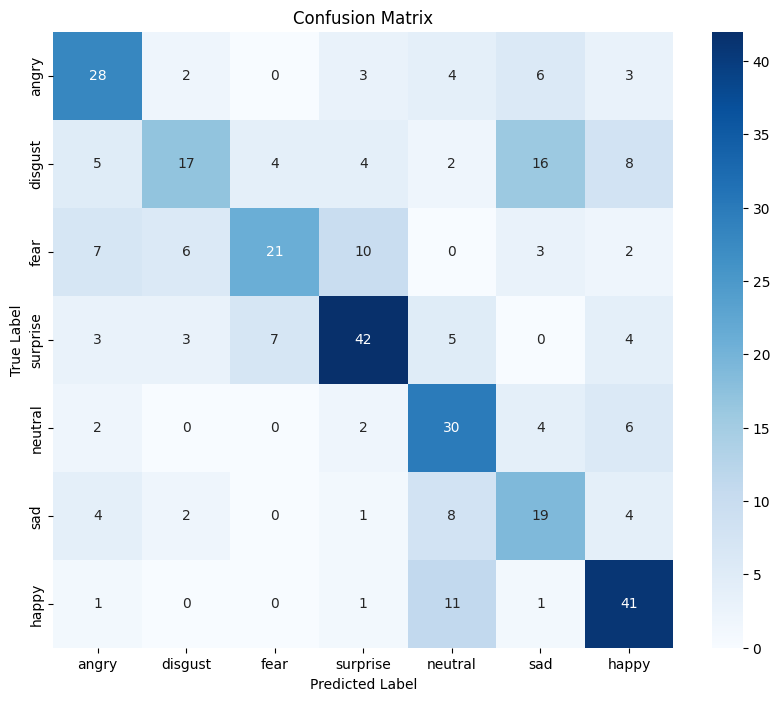

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


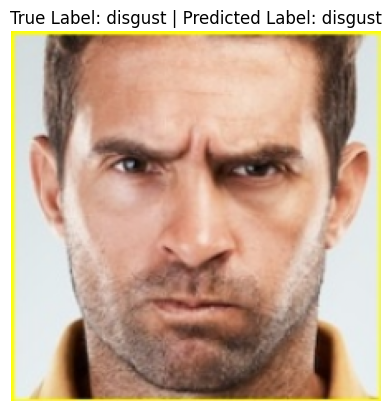

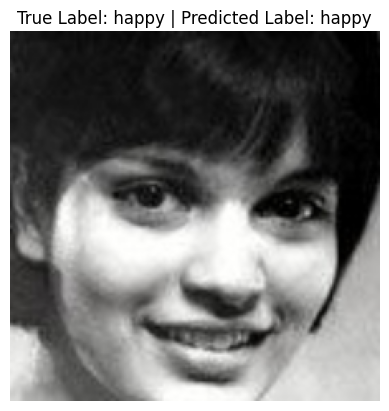

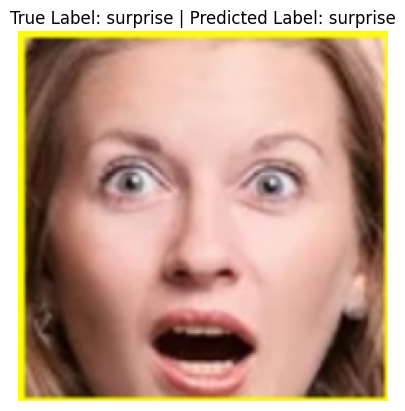

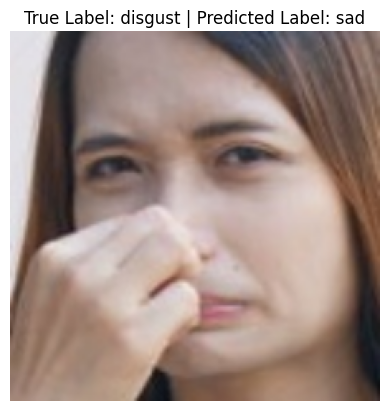

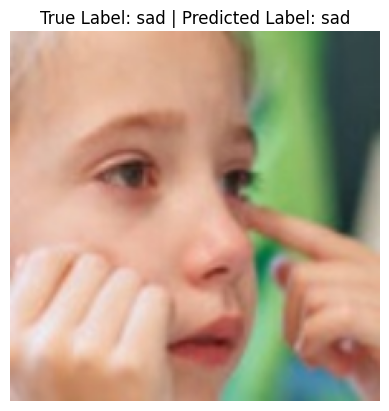

In [ ]:
# Test some images
def test_image(index):
    plt.imshow(X_test[index])
    plt.axis('off')
    plt.title("True Label: {} | Predicted Label: {}".format(class_names[y_true[index]], class_names[y_pred_classes[index]]))
    plt.show()

# Test random images
for _ in range(10):
    random_index = np.random.randint(0, len(X_test))
    test_image(random_index)


## *Model No.2 : MobileNet*

In [ ]:
from keras.applications import MobileNet

# Load the pre-trained VGG16 model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top of the pre-trained base
model = Sequential([
    base_model,
    Flatten(),
    # Dense(512, activation='relu'),
    # Dropout(0.5),
    # Dense(512, activation='relu'),
    # Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               25690624  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 28923079 (110.33 MB)
Trainable params: 25694215 (98.02 MB)
Non-trainable params: 3228864 (12.32 MB)
______

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/best_model.h5', monitor='val_loss', save_best_only=True)


In [ ]:
# Train the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=16),
                    steps_per_epoch=len(X_train) / 16, epochs=20,
                    validation_data=(X_val, y_val), callbacks=[early_stop, model_checkpoint])


Epoch 1/20
309/308 [==============================] - ETA: 0s - loss: 2.1031 - accuracy: 0.2819

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


308/308 [==============================] - 102s 296ms/step - loss: 2.1031 - accuracy: 0.2819 - val_loss: 1.5996 - val_accuracy: 0.3931
Epoch 2/20
308/308 [==============================] - 83s 267ms/step - loss: 1.6472 - accuracy: 0.3543 - val_loss: 1.4770 - val_accuracy: 0.4340
Epoch 3/20
308/308 [==============================] - 85s 275ms/step - loss: 1.5740 - accuracy: 0.3873 - val_loss: 1.4710 - val_accuracy: 0.4627
Epoch 4/20
308/308 [==============================] - 85s 274ms/step - loss: 1.5243 - accuracy: 0.4132 - val_loss: 1.4012 - val_accuracy: 0.4864
Epoch 5/20
308/308 [==============================] - 81s 261ms/step - loss: 1.4841 - accuracy: 0.4227 - val_loss: 1.3484 - val_accuracy: 0.4885
Epoch 6/20
308/308 [==============================] - 65s 211ms/step - loss: 1.4515 - accuracy: 0.4448 - val_loss: 1.3510 - val_accuracy: 0.4871
Epoch 7/20
308/308 [==============================] - 82s 265ms/step - loss: 1.4382 - accuracy: 0.4498 - val_loss: 1.3102 - val_accuracy: 0.

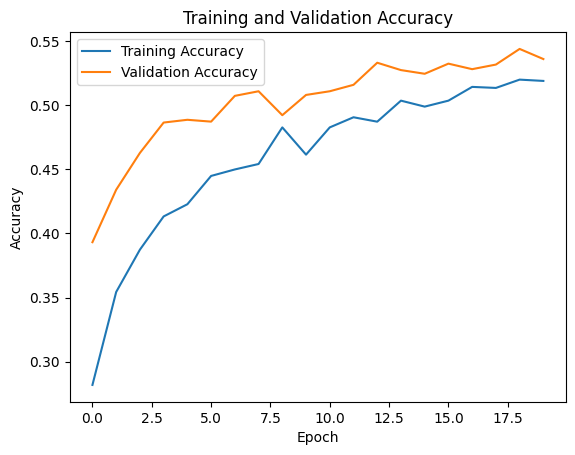

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


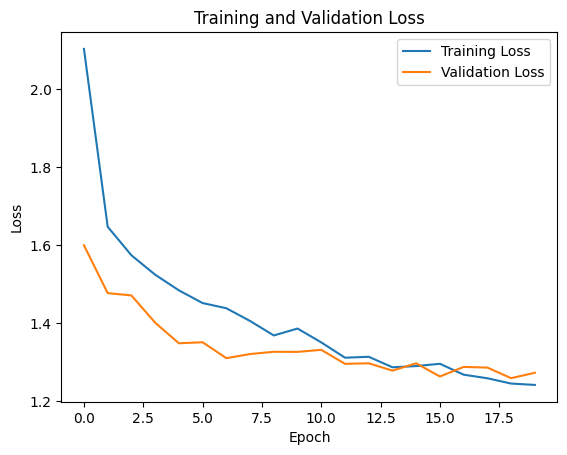

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

22/22 [==============================] - 1s 43ms/step - loss: 1.1416 - accuracy: 0.5781
Test Loss: 1.141600489616394
Test Accuracy: 0.578125


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))




22/22 [==============================] - 1s 39ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.42      0.47      0.44        89
     disgust       0.59      0.36      0.44       112
        fear       0.57      0.44      0.50       105
    surprise       0.68      0.74      0.71       132
     neutral       0.50      0.80      0.61        90
         sad       0.50      0.48      0.49        84
       happy       0.79      0.75      0.77        92

    accuracy                           0.58       704
   macro avg       0.58      0.58      0.57       704
weighted avg       0.59      0.58      0.57       704



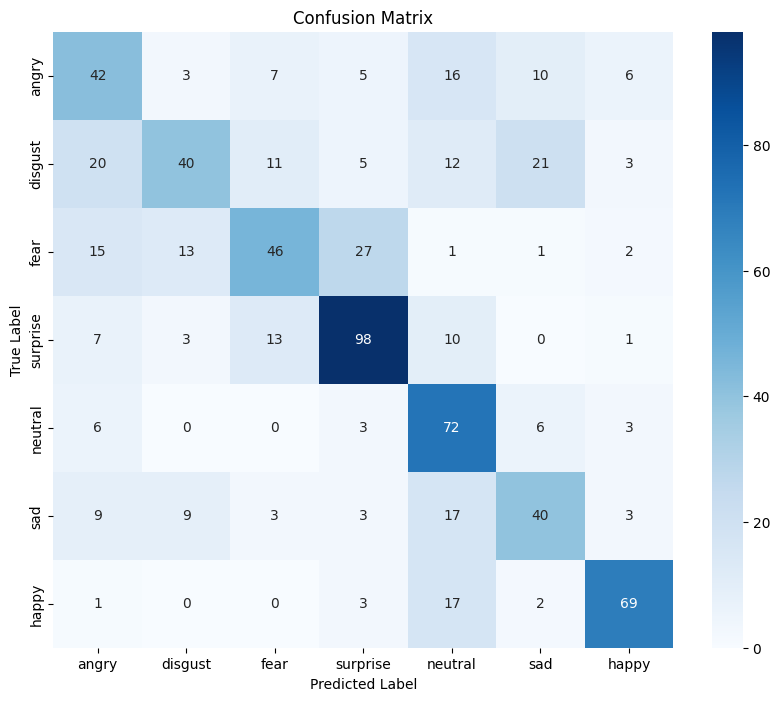

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


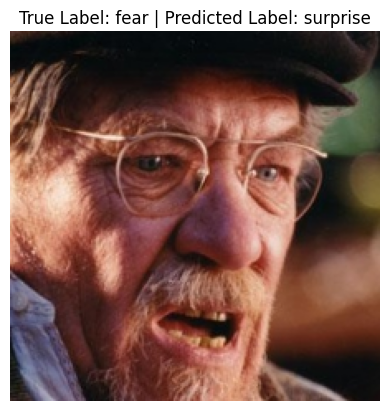

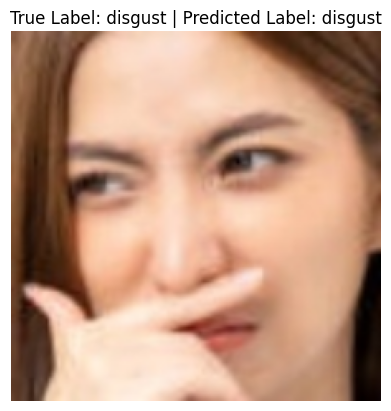

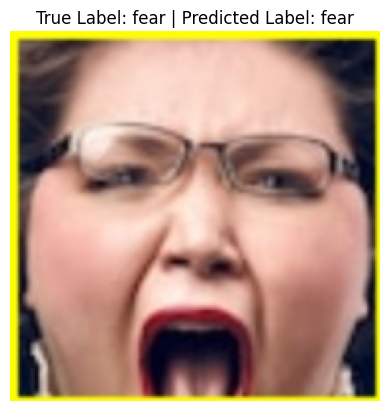

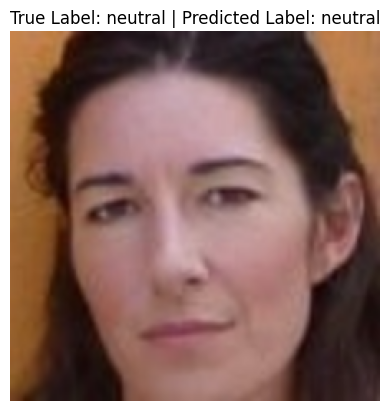

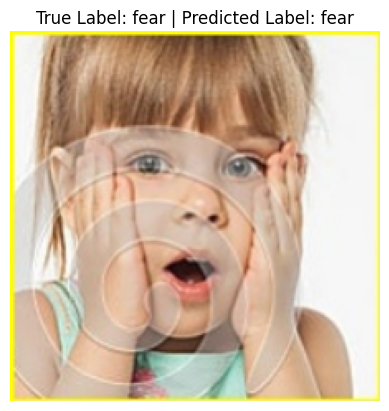

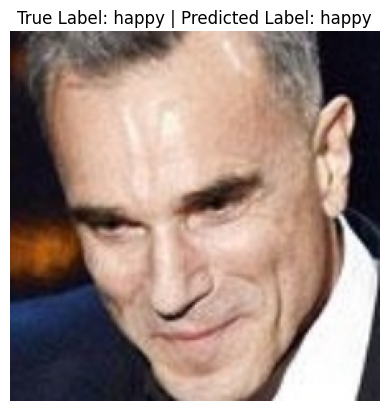

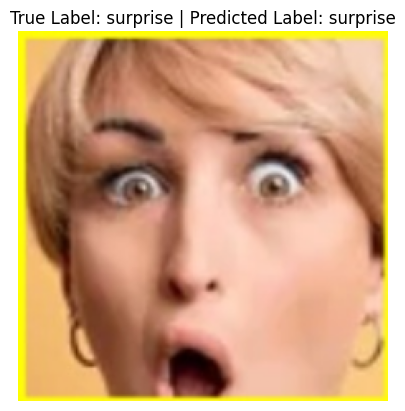

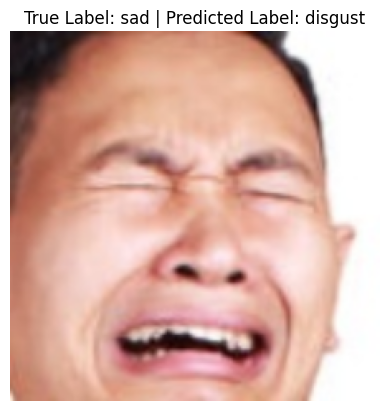

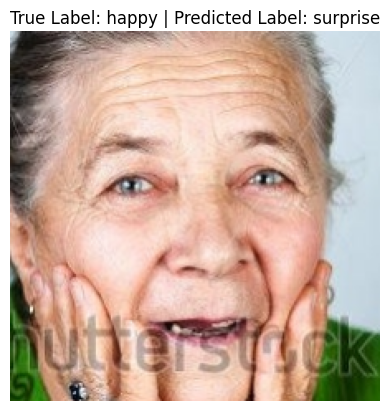

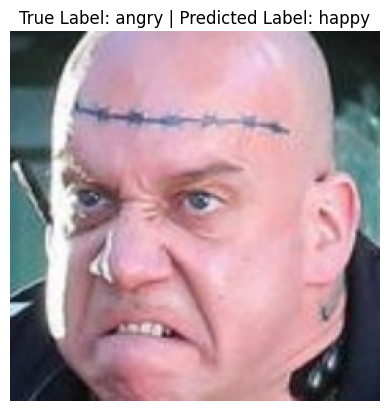

In [ ]:
# Test some images
def test_image(index):
    plt.imshow(X_test[index])
    plt.axis('off')
    plt.title("True Label: {} | Predicted Label: {}".format(class_names[y_true[index]], class_names[y_pred_classes[index]]))
    plt.show()

# Test random images
for _ in range(10):
    random_index = np.random.randint(0, len(X_test))
    test_image(random_index)


# **fine tine Mobilenet**

In [12]:
from keras.applications import MobileNet

# Load the pre-trained VGG16 model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the convolutional base
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all layers before the fine-tuned layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Create a new model on top of the pre-trained base
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               25690624  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/best_model.h5', monitor='val_loss', save_best_only=True)


In [14]:
# Train the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=16),
                    steps_per_epoch=len(X_train) / 16, epochs=30,
                    validation_data=(X_val, y_val), callbacks=[early_stop, model_checkpoint])


Epoch 1/30
309/308 [==============================] - ETA: 0s - loss: 2.0168 - accuracy: 0.2883

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


308/308 [==============================] - 141s 403ms/step - loss: 2.0168 - accuracy: 0.2883 - val_loss: 1.5596 - val_accuracy: 0.3989
Epoch 2/30
308/308 [==============================] - 113s 366ms/step - loss: 1.5983 - accuracy: 0.3766 - val_loss: 1.3907 - val_accuracy: 0.4756
Epoch 3/30
308/308 [==============================] - 82s 265ms/step - loss: 1.4729 - accuracy: 0.4359 - val_loss: 1.4203 - val_accuracy: 0.4914
Epoch 4/30
308/308 [==============================] - 110s 356ms/step - loss: 1.4245 - accuracy: 0.4593 - val_loss: 1.3291 - val_accuracy: 0.5208
Epoch 5/30
308/308 [==============================] - 122s 395ms/step - loss: 1.3862 - accuracy: 0.4759 - val_loss: 1.2874 - val_accuracy: 0.5308
Epoch 6/30
308/308 [==============================] - 82s 265ms/step - loss: 1.3269 - accuracy: 0.5002 - val_loss: 1.3534 - val_accuracy: 0.5301
Epoch 7/30
308/308 [==============================] - 81s 263ms/step - loss: 1.2813 - accuracy: 0.5210 - val_loss: 1.2907 - val_accuracy:

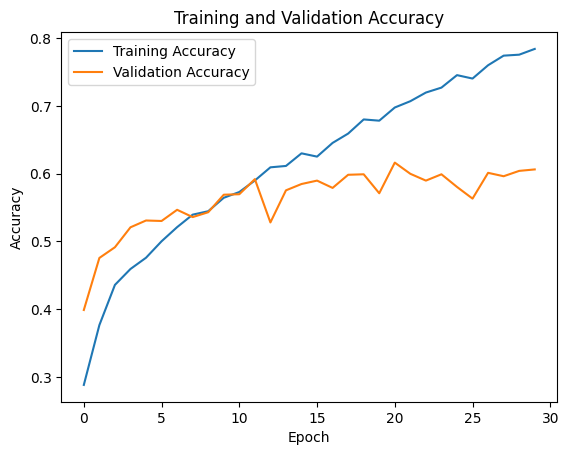

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


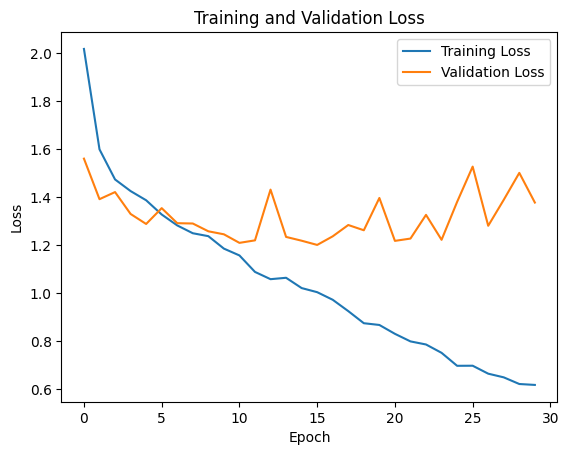

In [16]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

22/22 [==============================] - 1s 58ms/step - loss: 1.1713 - accuracy: 0.6705
Test Loss: 1.1712696552276611
Test Accuracy: 0.6704545617103577


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


22/22 [==============================] - 2s 45ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.63      0.59        89
     disgust       0.67      0.61      0.64       112
        fear       0.61      0.52      0.56       105
    surprise       0.78      0.78      0.78       132
     neutral       0.62      0.76      0.68        90
         sad       0.58      0.54      0.56        84
       happy       0.85      0.84      0.84        92

    accuracy                           0.67       704
   macro avg       0.66      0.67      0.66       704
weighted avg       0.67      0.67      0.67       704



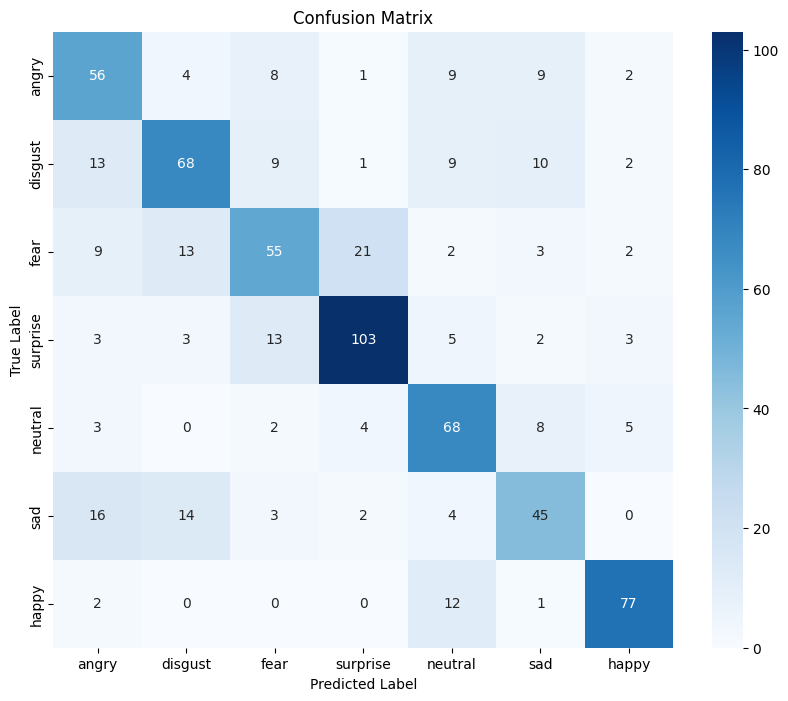

In [19]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


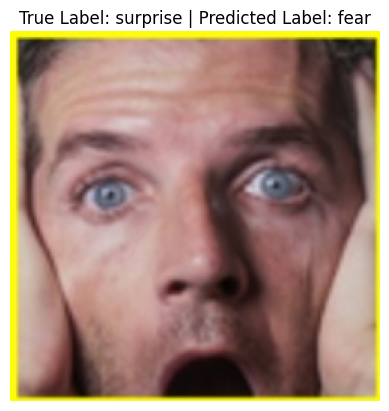

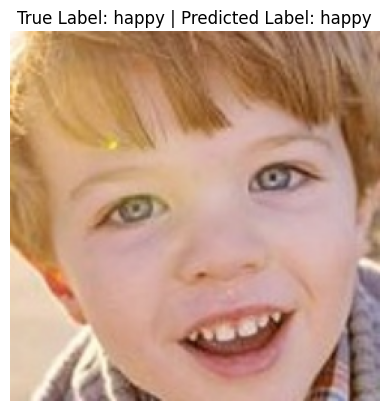

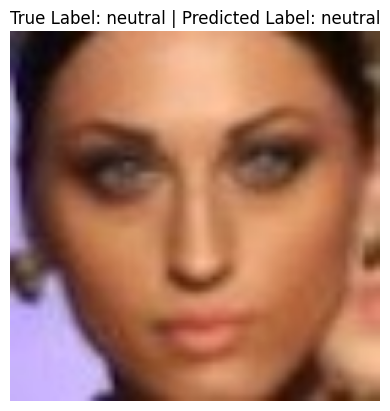

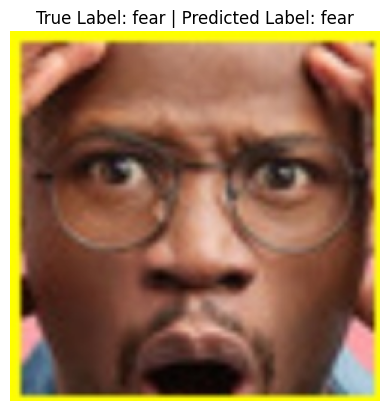

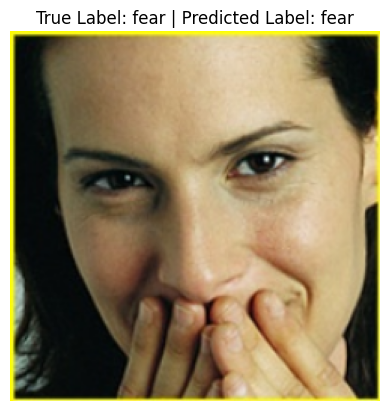

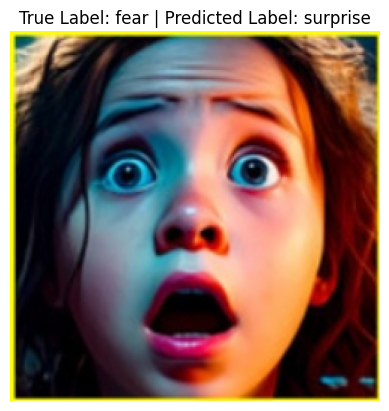

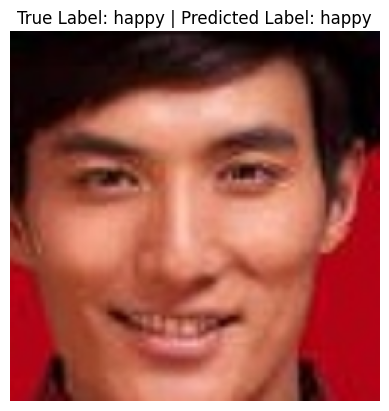

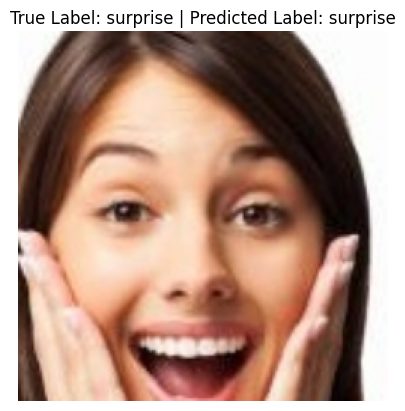

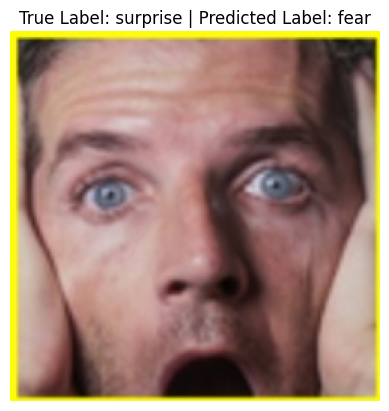

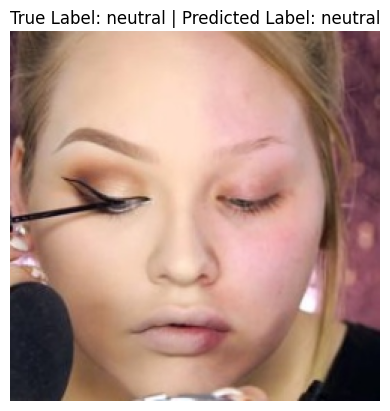

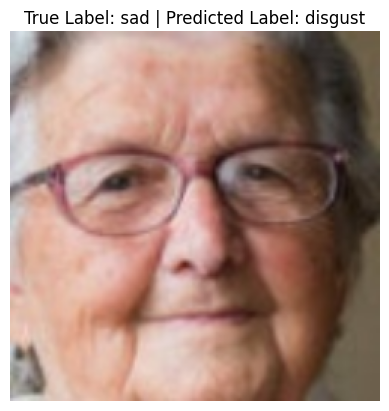

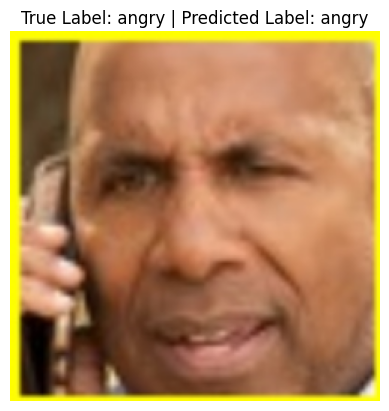

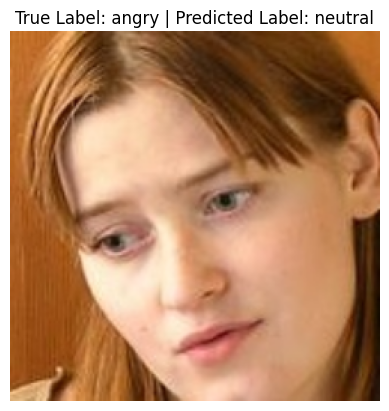

In [24]:
# Test some images
def test_image(index):
    plt.imshow(X_test[index])
    plt.axis('off')
    plt.title("True Label: {} | Predicted Label: {}".format(class_names[y_true[index]], class_names[y_pred_classes[index]]))
    plt.show()

# Test random images
for _ in range(13):
    random_index = np.random.randint(0, len(X_test))
    test_image(random_index)

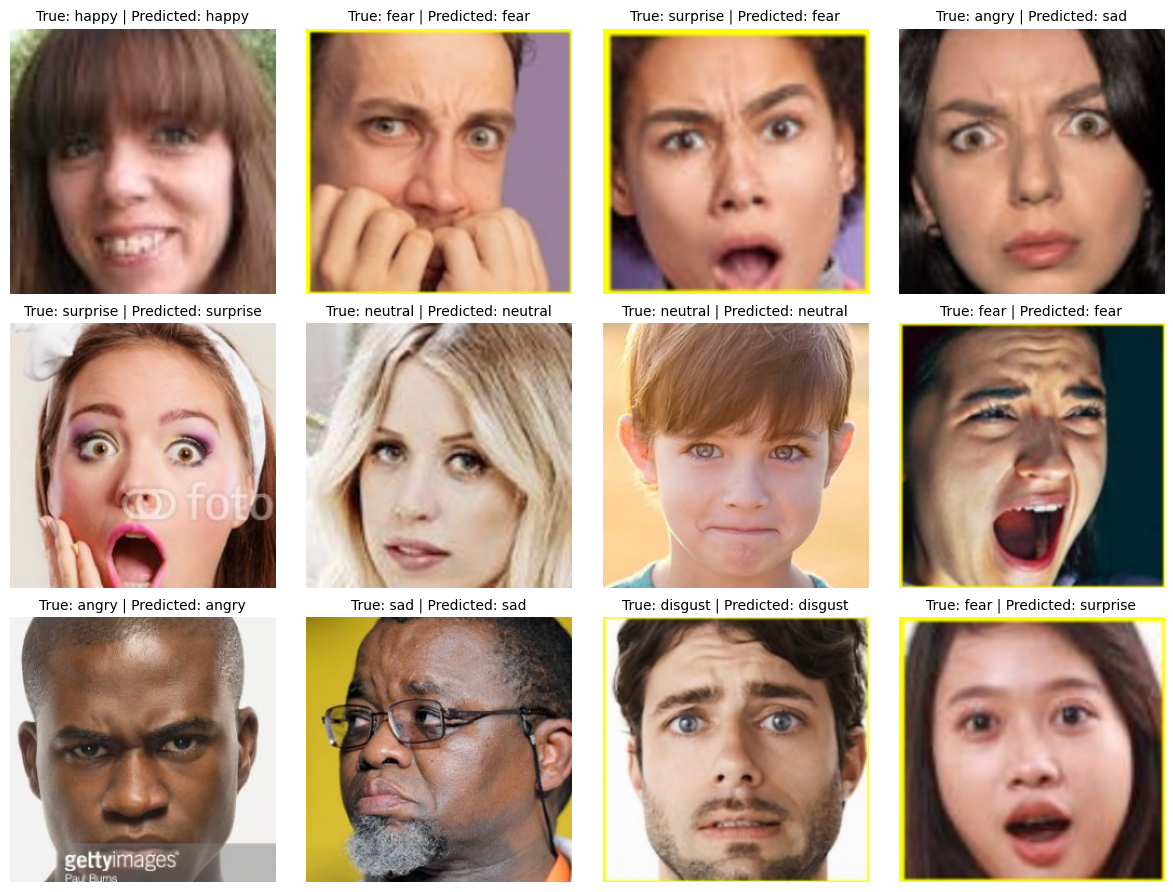

In [32]:
# Test some images in a 3x4 grid with reduced font size and gaps between images
def test_images(indices):
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)  # Add some gap between images
    axes = axes.flatten()
    for i, index in enumerate(indices):
        axes[i].imshow(X_test[index])
        axes[i].axis('off')
        axes[i].set_title("True: {} | Predicted: {}".format(class_names[y_true[index]], class_names[y_pred_classes[index]]), fontsize=10)
    plt.tight_layout()
    plt.show()

# Generate 3x4 random indices for testing
random_indices = [np.random.randint(0, len(X_test)) for _ in range(12)]
test_images(random_indices)
